# Modeling Simple World States With End-to-End Representation Learning

In this notebook, we'll begin by modeling simple continuous and discrete world states, using deep learning to learn powerful representations in an end-to-end fashion using backpropogation. 

## Simple Discrete World State

Let's begin by fomalizing the task at hand. We begin with a labeled dataset:

$\{(\textbf{x}_i, w_i)_{i=1}^N\}$, $\textbf{x}_i \in \mathbb{R}^m$, $w_i \in \mathbb{N}$

Here, $\textbf{x}_i$ in an m dimensional vector living in the vector space defined by $m$ cartesian products of the set of real numbers $\mathbb{R}$, and $w_i$ is a scaler, belonging to the set of natural numbers $\mathbb{N}$, (0, 1, 2, ... $\infty$). $x_i$ is a vector of features for a single observation, and $w_i$ is the world state corresponding to this observation. We want to develop a model for $pr(w_i | x_i)$.

Since our world state is discrete, we'll model this as:

$pr(w_i | x_i; \theta) = multinoulli_w[softmax(a_0, ..., a_{c - 1})]$, for $w_i \in \{0, ..., c - 1\}$

where $softmax(a_0, ..., a_{c-1})_k = \frac{e^{a_k}}{\sum_{j=0}^{c-1} e^j}$, and $a_k$ is the unnormalized log-probability corresponding to world state k, computed as $z_i^T\theta_k$, where $z_i = f(x_i)$ and $f:$ $\mathbb{R} \to \mathbb{R}$ is a (usually non-linear) mapping.

In [2]:
#TODO: Chapter before this "Modeling Simple World States" - Linear / non-linear regression; logsitic regression

In this chapter, we explore the approach of learning $f$ in an end-to-end fashion through backpropogation. This $z_i$ for a given observation then becomes a powerful learned representation of that observation, such that $pr(w_i | x_i)$ can be computed using the same fomulation as a linear c-class logistic regression model.

### Deep Neural Network

We first parameterize $f$ using a deep feedforward neural network, also known as a multi-layer perceptron. This network consists of layers of affine transformations, followed by element-wise non-linearities. Recall that any linear function $y=f(x)$, $y \in \mathbb{R}^m$ can be represented by a left matrix multiplication, $Ax=y$, $A \in \mathbb{R}^{m x n}$, $x \in \mathbb{R}^n$.

***

$\underline{Proof}$

A linear function is a mapping between two vector spaces that preserves scalar addition and scalar multiplication. Formally, a function $f$: $\mathbb{R}^n \to \mathbb{R}^m$ is linear iff $f(\textbf{x} + \textbf{y}) = f(\textbf{x}) + f(\textbf{y})$ and $f(\alpha \textbf{x}) = \alpha f(\textbf{x})$.

Let $f(\textbf{x}) = \textbf{A}\textbf{x}$. Then,

$f(\textbf{x} + \textbf{y}) = \textbf{A}(\textbf{x} + \textbf{y})$

= $\textbf{A}\textbf{x} + \textbf{A}\textbf{y}$ (distributive property of matrix multiplication)

= $f(\textbf{x}) + f(\textbf{y})$ (by definition)

Also,

$f(\alpha\textbf{x}) = A(\alpha\textbf{x})$

= $\alpha\textbf{A}\textbf{x}$ (scalar commutivity)

= $\alpha f(\textbf{x})$ (by definition)

***

So, by parameterizing layers in our network by $\Phi^T\textbf{x} + \textbf{b} = \textbf{y}$, $\Phi \in \mathbb{R}^{m x n}$, $\textbf{x} \in \mathbb{R}^n$, $\textbf{b} \in \mathbb{R}^m$, $\textbf{y} \in \mathbb{R}^m$, and estimating the parameters of $\Phi$ and $b$, we can, in theory, recover any affine function. It turns out that by introducing the correct element-wise nonlinearities, we can actually approximate any computable function in general, including highly non-linear mappings. A deep neural network is a function approximator! Learnability is not gauranteed however, since deep neural networks are usually optimizing very high-dimensional non-convex cost functions and finding the global optimum is extremely unlikely in these cases, but this is a very powerful property for our models to have, and in practice we are generally able to approximate very powerful and useful functions. In our current case, the functions we will be approximating are non-linear mappings from an input $x_i$ to a powerful representation $z_i$, from which we apply a simple linear probabalistic classifier to parameterize the conditional multinoulli distribution over simple discrete world states.

In [19]:
# TODO: Cite Multilayer feedforward networks with a nonpolynomial activation function can approximate any function

***

In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from core.models.three_layer_fc import SimpleFullyConnected
from core.optimizers.SGD import SGD
from core.training.trainer import ClassificationTrainer

In [18]:
# Set seeds for reproducibility
torch.manual_seed(22)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(22)
import random # This is needed for pytorch transforms
random.seed(22)

epoch (00001) -- training loss: (0.24559) -- training accuracy: (0.92712) -- validation loss (0.12013) -- validation accuracy: (0.96710)
epoch (00002) -- training loss: (0.10179) -- training accuracy: (0.97257) -- validation loss (0.10589) -- validation accuracy: (0.96970)
epoch (00003) -- training loss: (0.07237) -- training accuracy: (0.98080) -- validation loss (0.08455) -- validation accuracy: (0.97460)
epoch (00004) -- training loss: (0.05493) -- training accuracy: (0.98633) -- validation loss (0.07534) -- validation accuracy: (0.97870)
epoch (00005) -- training loss: (0.04495) -- training accuracy: (0.99002) -- validation loss (0.08014) -- validation accuracy: (0.97830)
epoch (00006) -- training loss: (0.03606) -- training accuracy: (0.99331) -- validation loss (0.07099) -- validation accuracy: (0.98060)
epoch (00007) -- training loss: (0.02978) -- training accuracy: (0.99534) -- validation loss (0.07206) -- validation accuracy: (0.98040)
epoch (00008) -- training loss: (0.02611)

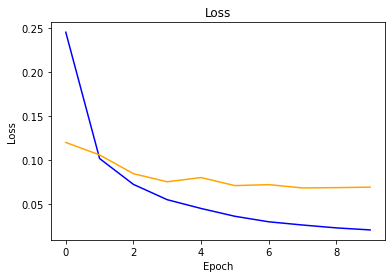

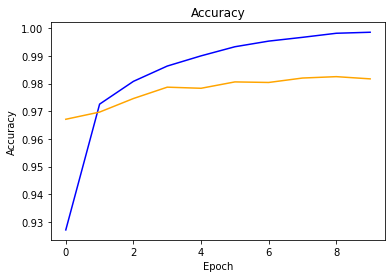

In [15]:
device = torch.device('cpu')
batch_size = 128

n_classes = 10
n_features = 28 * 28

# Set up data transformations / augmentations
transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                     mean=(0.1307,), std=(1,))
])

# Set up data source
mnist_train = torchvision.datasets.MNIST('data', train=True, download=True,
                                         transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

mnist_val = torchvision.datasets.MNIST('data', train=False, download=True,
                                       transform=transform)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False, drop_last=False)

# Build model with chosen hyperparameters
num_hidden = 328
weight_decay = 2e-5
lr = 8e-1
num_epochs = 10
net = SimpleFullyConnected(in_features=n_features, hidden_size=num_hidden, n_classes=n_classes,
                           weight_init='Kaiming')
net.to(device)
optim = SGD(params=net.get_params(), gradients=net.get_gradients(), lr=lr,
            weight_decay=weight_decay)
trainer = ClassificationTrainer(data_loader=train_loader, network=net,
                                optimizer=optim, len_training=len(mnist_train))
train_losses, train_accuracies, val_losses, val_accuracies = \
    trainer.train(num_epochs=num_epochs, device=device,
    validation_data_loader=val_loader,
    len_validation=len(mnist_val), verbose=True)

plt.plot(train_losses, c='b', label='train')
plt.plot(val_losses, c='orange', label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(train_accuracies, c='b', label='train')
plt.plot(val_accuracies, c='orange', label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()